# Finding the perfect match: A speed dating match classifier and potential social groups
## ITEC 657 Data Science Group Project
**Group S**
- Ka Yu Lau 41895118
- Jithendar Nethiram 44521987
- Suchith Kumar Suresh 45502897


# Executive Summary
This project started with an objective to understand the lifestyle of young people and the partner selection criteria of people. The aim was creating tools and indication for speed dating event host to group people who has a higher probability to find a match together in a event.

The first part of the project group people into 5 different clusters based on the lifestyle data from Slovak University of Technology. The Lifestyle clusters helps to group people with similar interest into one event. 

We have found income and age are the two most important factors affecting if a pair will end up with a match from speed dating. Decision Tree is the best performing model we built. The classifer was not consistent to unseen data as we see sign of overfitting. Further improvement will be needed.

# Introduction
Over the past two decades, more people tend use internet and dating applications to meet new partners. Online dating has even became the second most preferred way to meet a new partner, only behind introductions through family and friends. (Relationship Australia, 2017) The trend has put pressure on traditional speed dating event host to come up with better events to compete against these online dating sites and apps. 

The aim for people to attend speed dating event is finding someone meet their their partner selection criteria. It is reasonable that indiviuals lose interest in attending the events if they cannot find anyone matched. So the key quality measure of event is how easy the participants can find their match throughout the event. 

Match is defined as whether their partner in the event matches their criteria for a potential relationship. And our project focus aim to provide indication and tools for the event host how to can group people such that the chance getting a match increase.

### Project Goal
- To identify groups of people that share common interest or lifestlye
- To determine what is the most important factor for a pair of participant to match
- To create a classification model that classify whether a pair the male and female ending up a match in a speed dating event.


The result of these goals provides tools and indication for put participants together that increases the chance of match.

### Data Set and background

#### Lifestyle Dataset
The dataset is from a study and research from Slovak University of Technology , Bratislava. The Original study is focused on the Gender Interests match towards lifestyle and we use our study to match the cluster of common interests with respect to gender.

The data was survey by young people participants between age 15 - 30 and collected 1010 rows of data. Data is scaled in range of 1-5. where the 1 is the lowest rate and 5  is the highest rate. The data features are Music preferences,
Movie preferences,Hobbies & interests,Phobias,Health habits,Personality traits, views on life, & opinions,Spending habits,
Demographics.


#### Speed Dating Dataset
The dataset came from a study by Columbia Business School professors Ray Fisman and Sheena Iyengar. The original study focused on the gender difference in mate selection and our project aim to extend the use of the data to create classification model.

The data was collected from participants from 21 experimental speed dating events from 2002 – 2004. The attendees would have a four minutes ‘first date’ with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. And they will be asked to rate their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate and lifestyle information.


In this project, we only used the participant profile from the data for our interest to predict whether individuals can be match by only viewing their profile.



# Young People Survey - Cluster analysis

In [1]:
import pandas as pd
import numpy as np
from speeddate import extract_match, model_evaluation_score
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Read dataset
responces = pd.read_csv(filepath_or_buffer="responses.csv")
colms = pd.read_csv(filepath_or_buffer="columns.csv")
responces.head(2)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats


In the original data the there are 1010 observation and 150 variables.The Origanal column names was shortened in the data response file for convenience, our first analysis is going to be on finding the interest in shopping with respect to city and village for both the genders . Second We are splitting the data with respect to gender to find the common interests in shopping and spending with calibration model and then create clusters using K-mean model.  

In [3]:
# checking length of the column 
print("column len :",len(responces.columns))
data_cols = [responces.columns]
data_cols

column len : 150


[Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
        'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
        ...
        'Age', 'Height', 'Weight', 'Number of siblings', 'Gender',
        'Left - right handed', 'Education', 'Only child', 'Village - town',
        'House - block of flats'],
       dtype='object', length=150)]

In [4]:
#For convenience, the original variable names were shortened in the data file. See the columns.csv
colms.head()

,original,short
0,I enjoy listening to music.,Music
1,I prefer.,Slow songs or fast songs
2,"Dance, Disco, Funk",Dance
3,Folk music,Folk
4,Country,Country


In [5]:
# dropping the null values 
responces = responces.dropna()

## All participants were of Slovakian nationality, aged between 15-30.
### The variables can be split into the following groups:

Music preferences (19 items) <br>
Movie preferences (12 items) <br>
Hobbies & interests (32 items) <br>
Phobias (10 items) <br>
Health habits (3 items) <br>
Personality traits, views on life, & opinions (57 items) <br>
Spending habits (7 items) <br>
Demographics (10 items) <br>

In [6]:
music  = responces.iloc[:,0:19] 
movies = responces.iloc[:,20:31] 
phobias = responces.iloc[:,64:73] 
interests = responces.iloc[:,32:63] 
health = responces.iloc[:,74:76] 
personal = responces.iloc[:, 77:133] 
demo = responces.iloc[:,141:150] 
spending = responces.iloc[:,134:140]

In [7]:
movies.head(2)

,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action
0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,1.0,2.0
1,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,1.0,4.0


In [8]:
phobias.head(2)

,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking
0,1.0,1.0,1.0,1.0,5,3.0,1.0,3.0,2.0
1,1.0,1.0,2.0,1.0,1,1.0,3.0,1.0,4.0


## Data Preparation

In [9]:
responces.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,...,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,4.762611,3.295252,3.078635,2.264095,2.117211,2.982196,2.759644,3.451039,3.787834,2.354599,...,3.258160,3.026706,3.191395,3.096439,2.850148,3.514837,20.353116,173.419881,66.117211,1.299703
std,0.594699,0.795833,1.179841,1.120517,1.063888,1.244176,1.281403,1.165938,1.152979,1.396371,...,1.305537,1.305787,1.180771,1.208398,1.299140,1.076806,2.732763,9.475720,13.900289,0.992887
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,152.000000,41.000000,0.000000
25%,5.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,19.000000,167.000000,55.000000,1.000000
50%,5.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,20.000000,172.000000,63.000000,1.000000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,21.000000,180.000000,75.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,203.000000,150.000000,10.000000


In [10]:
#Spliting the Male data and Female data
male = responces[responces.Gender == "male"]
female = responces[responces.Gender == "female"]

## 1) Are there any differences in shopping interest with respect to village and city?

In [11]:
#We can Check who as more interest in shopping :city or village
city = responces[responces['Village - town'] == "city"]
village = responces[responces['Village - town'] == "village"]

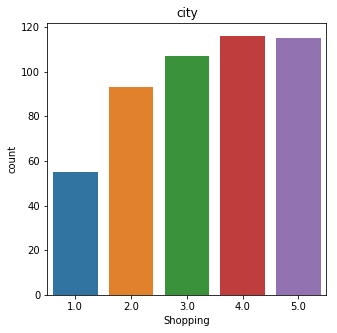

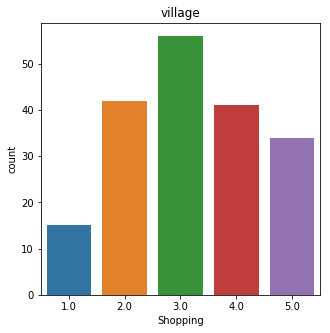

In [12]:
#1-5 is the Votes
lable_to_check = "Shopping"
figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=city['Shopping'],orient='h').set_title("city")

figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=village['Shopping'],orient='h').set_title("village")

plt.show()

We observe from data , City people Shopping interest is comparatively high than the village people. And Count also shows the most of city people have reviewed as rating 5

### People Shopping Interest and Spending Analysis

In [13]:
#All these are Features
movie_pref = responces.iloc[:,[0,19]]
personal = responces.iloc[:, 77:106] 
per1 = responces.iloc[:, 109:132]
spending_habits = responces.iloc[:,133:140] #This includes Hobbies and Stuffs
demotographies = responces.iloc[:,140:150]

In [14]:
#Prediction Class
predict = responces.iloc[:,57] #Level 1-5

In [15]:
#Dataframe to Join all these Variables
data_feed = movie_pref.join([personal,per1,spending_habits,demotographies,predict])

In [16]:
data_feed.head(2)

,Music,Movies,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,...,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Shopping
0,5.0,5.0,2.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,...,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats,4.0
1,4.0,5.0,2.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,...,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats,3.0


In [17]:
#Getting Dummy data for the Categorical Data
gender = pd.get_dummies(responces['Gender'])
handed = pd.get_dummies(responces['Left - right handed'])
num_child = pd.get_dummies(responces["Only child"])
village_town = pd.get_dummies(responces['Village - town'])
housing = pd.get_dummies(responces['House - block of flats'])
education = pd.get_dummies(responces['Education'])

But In Data Feed web have Numerical Data, so We need to Drop Them

In [18]:
data_feed[['Gender']].head(2)

,Gender
0,female
1,female


### Replacing with our Pre-Proprocessed Data with Pandas

In [19]:
data_feed.drop(labels=["Gender","Left - right handed","Only child","Village - town","House - block of flats","Education"],axis=1,inplace=True)

In [20]:
#Replacing the Data(Dummy Variables)
data_feed = data_feed.join([gender,handed,num_child,village_town,housing,education])

In [21]:
data_feed = data_feed.dropna()

## Instead of Doing a Multi-Class Classification for our Lables we Can Turn them into Binary Class Classification problem

In [22]:
data_feed.loc[data_feed['Shopping']<=3, 'Shopping'] = 0
data_feed.loc[data_feed['Shopping']>3, 'Shopping'] = 1

In [23]:
data_feed['Shopping'].head(3)

0    1.0
1    0.0
2    1.0
Name: Shopping, dtype: float64

In [24]:
#Setting up X and Y's for our Data set
X = data_feed.drop('Shopping', axis=1)
y = data_feed['Shopping']

from sklearn.model_selection import train_test_split
#Setting up Test and Validation sets for our Data using sklean
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)

## Searching for the Best value for the Parameter of the Log-Reg Model.

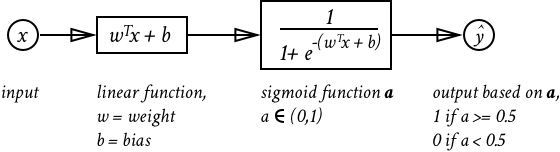

In [25]:
Image(filename="neuron.png",height=200,width=500)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [80]:
#This can be done by Backend Parameter Computing usig SearchCV
logistic_regression_model_cv = LogisticRegression(solver="lbfgs")
#C is the Inverse of the Regularization Strength
param_grid = {'C':[0.3,0.9,1.9,3.10,0.01]}
grid_search = GridSearchCV(logistic_regression_model_cv,param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(f'The Best Value of C is {grid_search.best_params_} for the Logistic Model')

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The Best Value of C is {'C': 0.3} for the Logistic Model


In [28]:
logistic_regression_model = LogisticRegression(C=0.3)
logistic_regression_model.fit(X_train,y_train)
print("Accuracy for the Logistic Mdoel is {:4f}".format(logistic_regression_model.score(X_test,y_test)))

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for the Logistic Mdoel is 0.733990


Fitted the data in Logestic best fit Regression model, we observe the best Value of C by grid Search method is 0.3 and Accuracy predicted is 0.733990 for Shopping interest in people with respect to other features in data.

## 2 Are there any differences in shopping interest with respect to Gender?

Plots respresents Shopping interest between male and female to find the interest in Gadgets and looks 

In [29]:
male = responces[responces['Gender'] == "male"]
female = responces[responces['Gender'] == "female"]

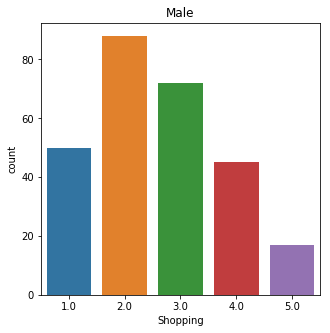

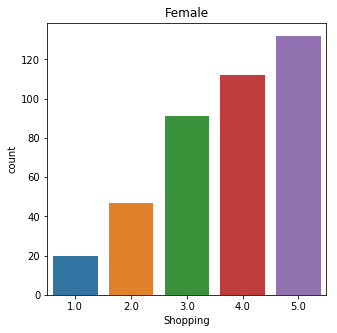

In [30]:
lable_to_check = "Shopping"
figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=male['Shopping'],orient='h').set_title("Male")

figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=female['Shopping'],orient='h').set_title("Female")
plt.show()

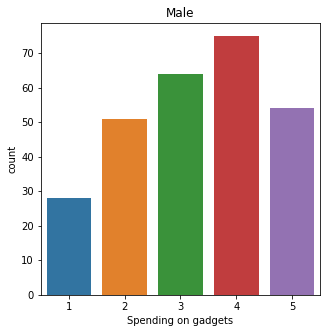

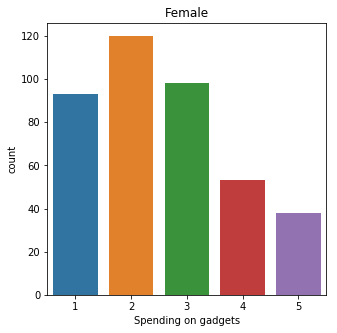

In [31]:
lable_to_check = "Spending on gadgets"
figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=male['Spending on gadgets'],orient='h').set_title("Male")

figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=female['Spending on gadgets'],orient='h').set_title("Female")
plt.show()

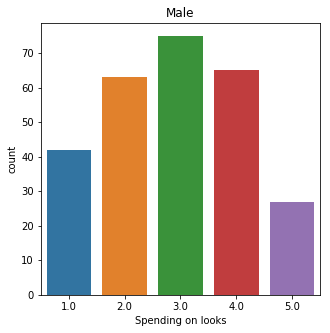

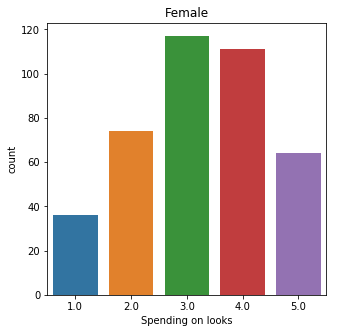

In [32]:
lable_to_check = "Spending on looks"
figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=male['Spending on looks'],orient='h').set_title("Male")

figure, axis = plt.subplots(figsize=(5,5))
sns.countplot(x=female['Spending on looks'],orient='h').set_title("Female")
plt.show()

By plotting the Graph we observe the Male interest is high in spending on Gadget compared to looks and Female interest is high on looks compared to gadgets¶

In [33]:
#splitting the data and choosing spending and demographic data as sample to find the spending between Gender
spending_habits = responces.iloc[:,133:140]
predict = responces.iloc[:,144] 
datafeed1=spending_habits.join([predict])
datafeed1=datafeed1.dropna()
datafeed1.head(2)

,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Gender
0,3.0,4.0,5.0,3.0,3.0,1,3.0,female
1,3.0,4.0,1.0,4.0,2.0,5,2.0,female


Splitting the data into Train and Test with training 70% and to predict the Accuracy by different model

In [34]:
#Setting up X and Y's for our Data set
X = datafeed1.drop('Gender', axis=1)
y = datafeed1['Gender']

from sklearn.model_selection import train_test_split
#Setting up Test and Validation sets for our Data using sklean
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42)

### Gaussian Naive Bayes 

In [35]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy on test set ",np.mean(y_pred==y_test))

Accuracy on test set  0.714285714286


### KNeighborsClassifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 
predictions =knn.predict(X_test)
print("Test set Accuracy is" ,np.mean(predictions==y_test))

Test set Accuracy is 0.660098522167


### Multinomial Naieve Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy on test set ",np.mean(y_pred==y_test))

Accuracy on test set  0.699507389163


We oserve from data MultinomialNB accuracy is 71% the prediction is better than the other model prediction used with data.

# Model Evaluation

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import calibration_curve

lr = LogisticRegression(C = 0.3)
gnb = GaussianNB()
knn = KNeighborsClassifier()
mul = MultinomialNB()

### Plot calibration plots and its comparision 

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


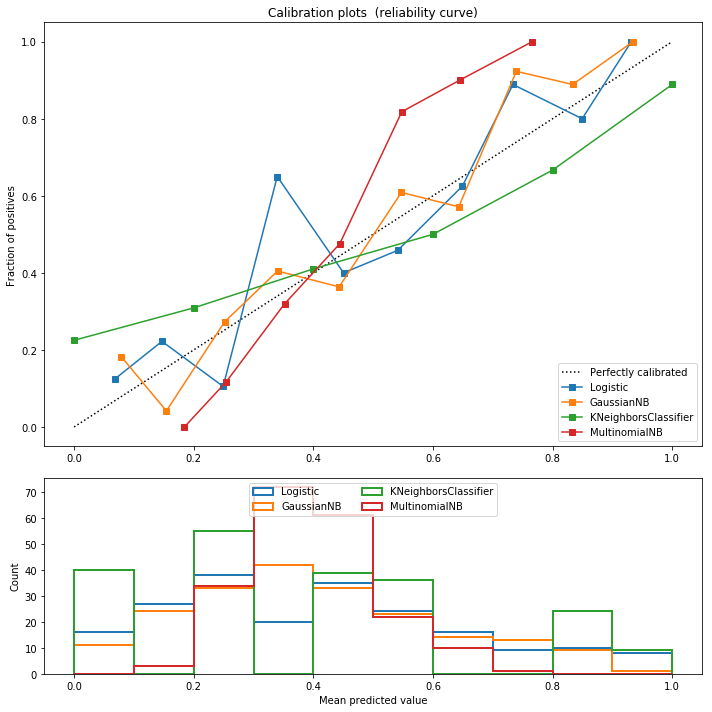

In [39]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'GaussianNB'),
                  (knn, 'KNeighborsClassifier'),(mul,'MultinomialNB')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Calibration plots are often line plots. Once I choose the number of bins and throw predictions into the bin, each bin is then converted to a dot on the plot. For each bin, the y-value is the proportion of true outcomes, and x-value is the mean predicted probability. Therefore, a well-calibrated model has a calibration curve that hugs the straight line y=x. 

### 3. Research analysis of data with respect to movie preferences feature between Gender using Clustering


In [40]:
movie_pref = responces.iloc[:,0:19] # various preferences of movies like Horror, thriller, Comedy, Romantic etc.
phobias = responces.iloc[:,63:73] # columns has only phobia related information
intrests = responces.iloc[:,31:63]
spending_habits = responces.iloc[:,133:140] #This includes Hobbies and Stuffs
res_feed = movie_pref.join([phobias,intrests,spending_habits]) # joining other selected features to the movie pref column
res_feed =res_feed.dropna()
res_feed.head(2)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Fun with friends,Adrenaline sports,Pets,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,5.0,4.0,4.0,3.0,4.0,5.0,3.0,3.0,1,3.0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,4.0,2.0,5.0,3.0,4.0,1.0,4.0,2.0,5,2.0


In [41]:
import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
Z = stats.zscore(res_feed)
#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(Z) # Fitting the 5 cluster using KMeans cluster to the model
labels = kmeans.labels_
res_feed['clusters'] = labels
#Lets analyze the clusters
print (res_feed.groupby(['clusters']).mean())

             Music  Slow songs or fast songs     Dance      Folk   Country  \
clusters                                                                     
0         4.608974                  3.493590  2.961538  1.737179  2.032051   
1         4.875000                  3.375000  3.187500  3.232143  2.848214   
2         4.800000                  3.361290  3.574194  1.974194  1.729032   
3         4.809859                  3.133803  3.338028  2.253521  2.105634   
4         4.752294                  3.045872  2.091743  2.449541  2.055046   

          Classical music   Musical       Pop      Rock  Metal or Hardrock  \
clusters                                                                     
0                2.423077  1.858974  3.250000  3.788462           2.698718   
1                3.991071  3.267857  3.241071  4.232143           3.062500   
2                2.161290  2.748387  4.109677  3.187097           1.503226   
3                3.218310  3.239437  3.704225  3.929577        

In [81]:
# Splitting the train and test data keeping test data of about 30%
X2 = res_feed.drop('clusters', axis=1)
y2 = res_feed['clusters']
clf = LogisticRegression(solver='lbfgs')
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,random_state=0, test_size=0.3)
clf.fit(X2_train, y2_train)
print("model score: %.3f" % clf.score(X2_test, y2_test)) 

model score: 0.813


/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs f

### Knn Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X2_train, y2_train) 
predictions =knn.predict(X2_test)
print("Test set Accuracy is" ,np.mean(predictions==y2_test)) 

Test set Accuracy is 0.645320197044


### Gaussian Naive Baye's

In [44]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
clf.fit(X2_train, y2_train)
y2_pred=clf.predict(X2_test)
print("Accuracy on test set", np.mean(y2_pred==y2_test))

Accuracy on test set 0.87684729064


### MLP Classifier

In [45]:
from sklearn.neural_network import MLPClassifier
import numpy as np
clf=MLPClassifier(random_state=0)
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)
print("Accuracy on test set", np.mean(y2_pred==y2_test))

Accuracy on test set 0.817733990148


/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


From the above prediction analysis, Gaussian Naives bayes has better accuracy result

### Plotting cluster between 5 different Preferences of movie

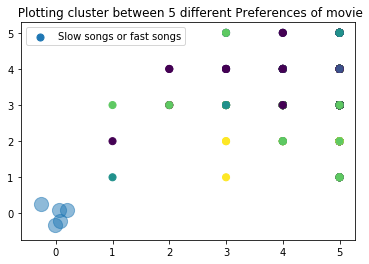

In [47]:
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)
plt.scatter(X2.iloc[:, 0], X2.iloc[:, 1], c=y_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5)
plt.title(' Plotting cluster between 5 different Preferences of movie')
plt.legend(loc='best')
plt.show()

 Kmeans is an unsupervised learning algorithm. Algorithm categorize the items into K groups of similarity. First it initializes K mean value randomly and categorize each items to its closed mean. Also take different mean values which doesn't match to the first initialize mean during iteration of items. so like this we get group of clusters with similarity in items using mean value.

# Speed Dating Experiment - Match classifier
## Data Preprocessing

In [83]:
#read file
SpeedDate = pd.read_csv('annavmontoya-speed-dating-experiment/Speed Dating Data.csv',sep=',', engine='python')

The original speed dating data contains 8378 observations with 195 variables. 

In this project, we are not interested to how the participant rate their partners after the date as this is usually not collectable from individuals by event host. We only select basic attributes of the participants such as age, income, race, field of work or study, orign, their go out pattern and their interests as our predictors. 

Our preprocessing has three major steps. First we create a data frame with all the pairs of the speed dating events and whether they match. Second we create a data frame for the profile of each the participants. Last we will map the profiles to the first data frame and compare the differences between the profiles of the participant and the partner and create the input data for our model building.

In [84]:
#First Data Frame
#setting up target and response
data = ['match','iid','pid']
match = SpeedDate[data].dropna()
match.head()

,match,iid,pid
0,0,1,11.0
1,0,1,12.0
2,1,1,13.0
3,1,1,14.0
4,1,1,15.0


In [85]:
#Second Data Frame
#create a dataframe with the selected columns
profile = SpeedDate[['iid','gender', 'age','income','race','field_cd','from','go_out', #basic demographic charateristics
          'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',#interest
           'tv','theater', 'movies','concerts','music',
                     'shopping','yoga']].drop_duplicates(subset='iid',keep='first') #pick only the first records
profile.head()

,iid,gender,age,income,race,field_cd,from,go_out,sports,tvsports,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,1,0,21.0,"69,487.00",4.0,1.0,Chicago,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
10,2,0,24.0,"65,929.00",2.0,1.0,Alabama,1.0,3.0,2.0,...,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0
20,3,0,25.0,NaN,2.0,2.0,Connecticut,1.0,3.0,8.0,...,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0
30,4,0,23.0,"37,754.00",2.0,1.0,Texas,1.0,1.0,1.0,...,5.0,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0
40,5,0,21.0,"86,340.00",2.0,1.0,Bowdoin College,1.0,7.0,4.0,...,6.0,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0


### Missing Value Treatment
Below are the number of missing value of each column. As the missing value in income is significant to the total number of observations, We will fill this missing value with the mean income. We also filled missing value in age with mean age. The missing value in rest of the variables is small so we drop those records from our analysis.

In [86]:
profile.isnull().sum()

iid           0
gender        0
age           8
income      270
race          6
field_cd      7
from          7
go_out        7
sports        7
tvsports      7
exercise      7
dining        7
museums       7
art           7
hiking        7
gaming        7
clubbing      7
reading       7
tv            7
theater       7
movies        7
concerts      7
music         7
shopping      7
yoga          7
dtype: int64

In [87]:
#cleaning the column income
#remove comma in each of the records so mean can be calculated
import re
for i in range(0,len(profile['income'])):
    
    if pd.isnull(profile['income'].iloc[i])== True:
        pass
    else:
        profile['income'].iloc[i] = float(re.sub(',','',profile['income'].iloc[i]))

#filled missing income with mean
profile['income'] = profile['income'].fillna(profile['income'].mean()) 

/Users/garylau/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [88]:
#drop all remaining na
profile['age']= profile['age'].fillna(profile['age'].mean())
profile= profile.fillna(0)

### Data Transformation
As we are only interested whether the participant and their partner share similar interest, we have recode the ranking of interest. For interest that the participant ranked top 3, we assume the participant is 'interested' to that interest and rest are 'not interested'.

In [54]:
interest = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',
           'tv','theater', 'movies','concerts','music','shopping','yoga'] # a list of interest
#convert the top 3 interest into 1 else 0
for i in interest:
    profile[i]= profile[i].replace([1,2,3],1)
    profile[i]= profile[i].replace(range(4,11),0)

In [55]:
#Third Data Frame
# Map the profiles difference with whether the date result is a match or not
diff = pd.DataFrame()
for obs in range(1,len(match)):
    if match['iid'].iloc[obs] in profile['iid'].unique() and int(match['pid'].iloc[obs]) in profile['iid'].unique():
        diff = diff.append(extract_match(match, profile, interest, obs))

diff.head() #prepared data frame

,age,field_cd,go_out,income,interest,match,origin,race
0,-1.0,0,0,40250.000000,1,0,0,0
0,-1.0,0,0,24201.362989,1,1,0,0
0,-2.0,0,0,12907.000000,4,1,0,0
0,-3.0,0,0,32705.000000,2,1,0,0
0,-4.0,0,0,24201.362989,2,0,0,0


## Data Exploration

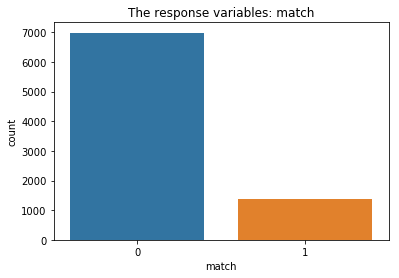

In [56]:
sns.countplot(diff['match'])
plt.title('The response variables: match')
plt.show()

Only 12% of the dates end up with a match. We have modeled based on this data but it is found that models created has high accuracy but low AUC. To deal with the unbalanced target variable, we will perform oversampling the minority group (match). And in order to make sure the consistancy of our result, we will split the data train, valid and test before our model building. Oversampling will only be done on train and valid data while we will use the test data to be our gatekeeper to ensure consistency when we feed unmodified data into the model.

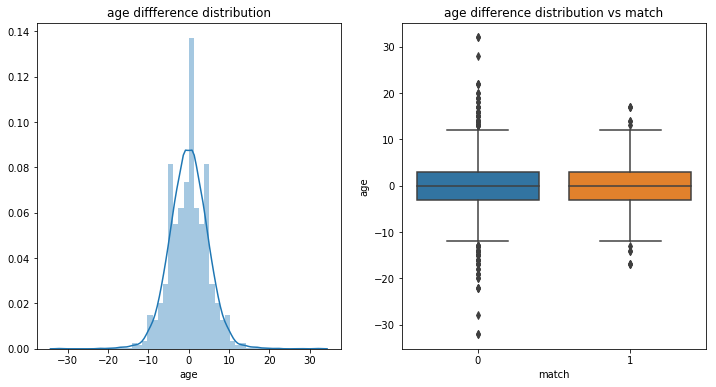

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.distplot(diff.age)
plt.title('age diffference distribution')
plt.subplot(122)
sns.boxplot(y = diff.age,x = diff.match)
plt.title('age difference distribution vs match')
plt.show()

The age difference between the participants and their partners is approximately normally distributed at 0. From the boxplot, age difference doesn't appears to have any significant different between match or not match.

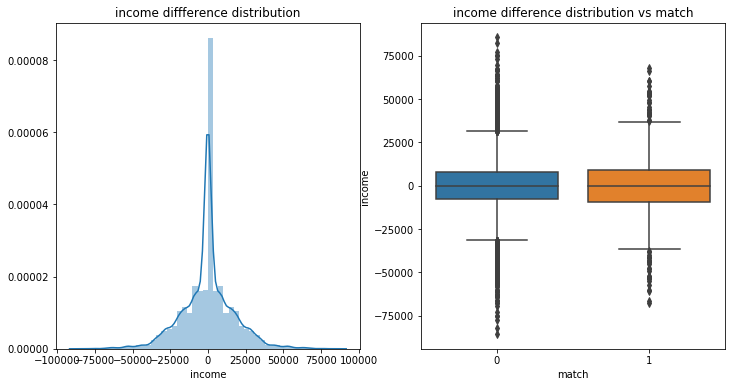

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.distplot(diff.income)
plt.title('income diffference distribution')
plt.subplot(122)
sns.boxplot(y = diff.income,x = diff.match)
plt.title('income difference distribution vs match')
plt.show()

Similarly, income difference between the participants and their partners is also approximately normally distributed. The boxplot shows pair did not match is more widely spreaded but there are no significant differences in median of income difference on whether the pairs is a match or not.

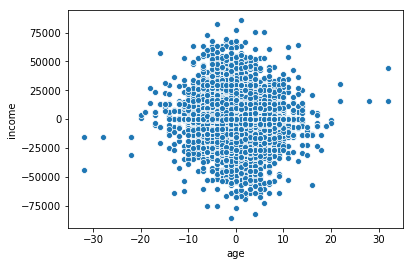

In [59]:
sns.scatterplot(diff.age,diff.income)
plt.show()

From the scatterplot, income difference and age difference are not correlated so it is safe for us to use them as predictors.

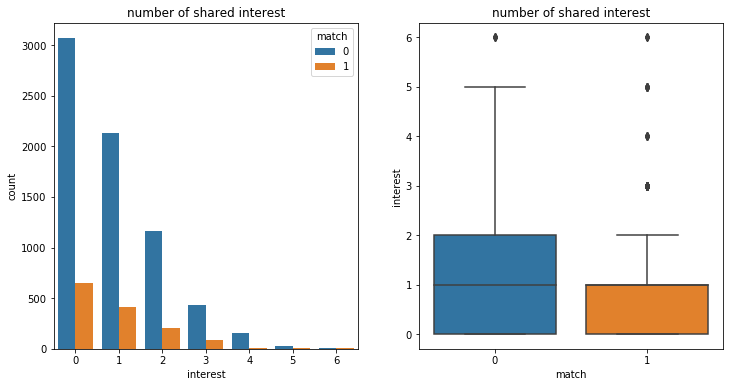

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.countplot(diff['interest'],hue=diff.match)
plt.title('number of shared interest')
plt.subplot(122)
sns.boxplot(y = diff.interest,x = diff.match)
plt.title('number of shared interest')
plt.show()

For above, we can see pairs ends up with a match generally shared less interest than pairs do not match.

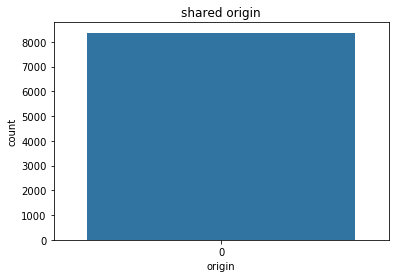

In [61]:
sns.countplot(diff['origin'])
plt.title('shared origin')
plt.show()

None of the pairs shared the same origin. Hence, the variable no longer useful and we will drop this variable in our model building.

# Model Building

In the coming section, we will use different algorithms to train the classification model to classify whether the speed dating pair will be a match to the participant. As mentioned earlier, we will split the data into 3 parts.

In [62]:
target = diff['match']
data = diff.drop(['match','origin'],axis=1)
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(data, target, random_state=123, train_size=0.8, test_size = 0.2)
diff_n = pd.concat([X,y],axis=1)

In [63]:
from sklearn.utils import resample
# Separate majority and minority classes
majority = diff_n[diff_n.match==0]
minority = diff_n[diff_n.match==1]
 
# Oversampleing majority class
resample = resample(minority, 
                    replace=True,    # sample without replacement
                    n_samples=int(diff_n.match.value_counts()[0]*0.7),     # to match minority class
                    random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
diff_n = pd.concat([resample, majority])
 
# Display new class counts
print("The processed dataset has response as follow: ")
print(diff_n.match.value_counts())

The processed dataset has response as follow: 
0    5594
1    3915
Name: match, dtype: int64


In [64]:
#creating data frame for target and features
target = diff_n['match']
data = diff_n.drop('match',axis=1)

In [65]:
#split the data
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(data, target, random_state=123, train_size=0.7,test_size=0.3)

In [66]:
# initialise lists to store the evaluation of different model
train_acc = []
train_auc = []
test_acc =[]
test_auc = []
valid_acc=[]
valid_auc=[]

### Logistic Regression
Logistic regression is estimating the parameters of a logistic model; it is a form of binomial regressiom. It took the predictors to estimate the probability of the response class.

In [67]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
lr_score = model_evaluation_score(logreg, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(lr_score['train_acc'])
train_auc.append(lr_score['train_auc'])
test_acc.append(lr_score['test_acc'])
test_auc.append(lr_score['test_auc'])
valid_acc.append(lr_score['valid_acc'])
valid_auc.append(lr_score['valid_auc'])

### K-nearest Neighbors (KNN)
In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. It calculate the 'how difference' the instance to the target class and classify based on which is the nearest class

In [68]:
# K-nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_score = model_evaluation_score(knn, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(knn_score['train_acc'])
train_auc.append(knn_score['train_auc'])
test_acc.append(knn_score['test_acc'])
test_auc.append(knn_score['test_auc'])
valid_acc.append(knn_score['valid_acc'])
valid_auc.append(knn_score['valid_auc'])

### Naive Bayes

In machine learning, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features. We train the model based on the occurence of a certain feature in the prior observation and classify based on if that feature appears in the posterior observation.

In [69]:
# Gaussian Naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_score = model_evaluation_score(gnb, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(gnb_score['train_acc'])
train_auc.append(gnb_score['train_auc'])
test_acc.append(gnb_score['test_acc'])
test_auc.append(gnb_score['test_auc'])
valid_acc.append(gnb_score['valid_acc'])
valid_auc.append(gnb_score['valid_auc'])

### Neural Network
Neural Network used a simulation of neuron from the brain. It starts with assigning random weight in the calculation of probability of class that the observation belongs. And by readjusting the weight in different layers when it makes an error, the algorithm modified the weight automatically to give better result.

In [70]:
# Neural Network
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(10), alpha=0.0001, random_state=0)
mlpc.fit(X_train,y_train)
mlpc_score = model_evaluation_score(mlpc,X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(mlpc_score['train_acc'])
train_auc.append(mlpc_score['train_auc'])
test_acc.append(mlpc_score['test_acc'])
test_auc.append(mlpc_score['test_auc'])
valid_acc.append(mlpc_score['valid_acc'])
valid_auc.append(mlpc_score['valid_auc'])

### Decision Tree
A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility.

In [71]:
# Descision Treee
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0,min_samples_split=5)
dtree.fit(X_train, y_train)
dtree_score = model_evaluation_score(dtree, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(dtree_score['train_acc'])
train_auc.append(dtree_score['train_auc'])
test_acc.append(dtree_score['test_acc'])
test_auc.append(dtree_score['test_auc'])
valid_acc.append(dtree_score['valid_acc'])
valid_auc.append(dtree_score['valid_auc'])

After fitting different model, we create a data frame to display the Accuracy and AUC to mesure the performance of different models.

In [72]:
# Display the training and testing acc, auc
model = ['logreg','knn','gnb','nn','tree']
model_evaluation = pd.DataFrame({'model':model,
                                'train_acc':train_acc,
                                'train_auc':train_auc,
                                'valid_acc':valid_acc,
                                'valid_auc':valid_auc,
                                'test_acc':test_acc,
                                'test_auc':test_auc})
model_evaluation

,model,test_acc,test_auc,train_acc,train_auc,valid_acc,valid_auc
0,logreg,0.814815,0.502967,0.586388,0.516014,0.577638,0.509837
1,knn,0.689367,0.522166,0.884465,0.880473,0.781633,0.786512
2,gnb,0.830346,0.554100,0.589844,0.538257,0.583246,0.558830
3,nn,0.599164,0.529374,0.527644,0.513001,0.511742,0.499436
4,tree,0.685783,0.499833,0.890475,0.970450,0.767964,0.838165


Accuracy and AUC provide an indication how well the model classify the observation into target group. From the above table, knn and decision tree shows high accurary and auc (above 75%) in their training and validation stage. However, the auc drop sharply when we use the model to predict the test data. This indicated the model has been overfitting.

We have tried different ratio of over-sampling and down-sampling, but the AUC remained at around 50% which did not do better prediction than not having the model.

The reason of this is likely we did not capture the right features in our data. As we saw that from the data exloration did not have any difference in no matter the pairs match or not match.

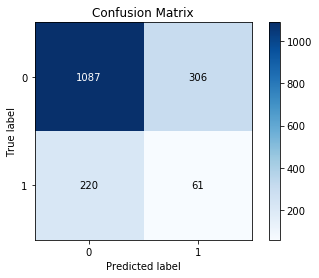

In [73]:
import scikitplot as skplt
predicted_test = dtree.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, predicted_test)
plt.show()

The confusion matrix provide information what are the false positive and false negative the model is making. As seen above, The model tends to predict the majority(not match) class right but can hardly classified match.

In [74]:
#feature importance
from sklearn.feature_selection import RFE
selector = RFE(dtree, 1, step=1)
selector = selector.fit(X_train, y_train)
print(X_train.columns)
print(selector.ranking_)

Index(['age', 'field_cd', 'go_out', 'income', 'interest', 'race'], dtype='object')
[2 6 5 1 3 4]


Income is found to be the most important variables with age come second. The importance of these two features can also be seen in the Decision Tree Plot below. The tree splits based on income and age in first two levels of split.

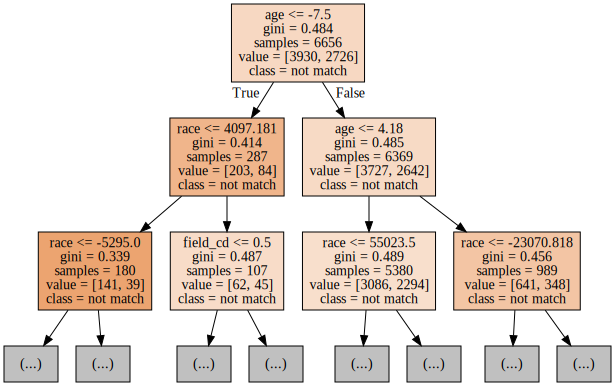

In [75]:
# Visualize the decision Tree
from sklearn import tree
import graphviz 
import pydotplus
dtree = dtree.fit(X_train, y_train)
dot_data = tree.export_graphviz(dtree, out_file=None,max_depth = 2,
                                feature_names = ['age', 'go_out', 'income', 'race','field_cd','interest'], class_names=['not match','match'],
                               filled = True) 
graph = graphviz.Source(dot_data) 
graph

# Summary and future improvement

To conclude, our project aim to provide indication for speed dating event host to group people that share common interest or more likely to find each other match their partner selection criteria.

The first part of the project group people into 5 different clusters based on the lifestyle data from Slovak University of Technology. The **Lifestyle clusters** helps to group people with similar interest into one event. 

We see that MLP Classifier giving the best Test Accuracy Results from the following 5 clusters of Data. We can best classify view of Shopping interest based on City and Village (73%) with Logistic best fit model and best value of C by grid Search. 

We can best classify view of Gender based on spending habits (71%) with MulnomialNB model.

It is clear from plot that among whole Movie preferences, thriller movie has most common choices between Gender found by Kmeans Clustering. We can best classify view of Gender based on Movies habits with help of cluster (81%) with MLP classifier.

However, the model is limited to Slovakia region as the data used to train the model only contains people around that region. To have a result that is more representative to the population, we need to have broader range of sample from various culture and cities.

The second part of the project is a **Speed Dating Match Classifier** that classify if a pair in speed dating will result a match. Interest and age is the most important feature. Decision Tree gave the best performance among all other algorithm used with train accuracy and auc and validation accuracy and auc over 75%. However, the model is over fitted as AUC dropped rapidly when we tried to predict with the test data. This indicated the model created is unreliable.

This may caused by serveral reasons:
- there sample size is not large enough to represent the population
- variables in profile is not the right feature for the classification, we can extend the model by using the selection criteria questionaire result
- the original paper of the speed dating data also suggested male and female has different selection criteria, our model did not specified this. We may improve the model by spliting the model into two for male and female.


# Reference
Relationship Australia, 2017:https://www.relationships.org.au/what-we-do/research/online-survey/november-2017-online-dating